In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import math
from keras import Sequential
from keras.src.applications import VGG16, VGG19
from keras.src.callbacks import ModelCheckpoint
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.src.optimizers.legacy.rmsprop import RMSprop
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from keras.src.preprocessing.image import ImageDataGenerator
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
cat_train_dir = "./img/train/cat"
cat_validation_dir = "./img/validation/cat"
cat_test_dir = "./img/test/cat"

dog_train_dir = "./img/train/dog"
dog_validation_dir = "./img/validation/dog"
dog_test_dir = "./img/test/dog"

In [3]:
print(f"Cat train images: {len(os.listdir(cat_train_dir))}")
print(f"Cat validation images: {len(os.listdir(cat_validation_dir))}")
print(f"Cat test images: {len(os.listdir(cat_test_dir))}")

print(f"Dog train images: {len(os.listdir(dog_train_dir))}")
print(f"Dog validation images: {len(os.listdir(dog_validation_dir))}")
print(f"Dog test images: {len(os.listdir(dog_test_dir))}")

Cat train images: 148
Cat validation images: 43
Cat test images: 32
Dog train images: 148
Dog validation images: 43
Dog test images: 32


In [4]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    fill_mode="nearest",
    shear_range=0.2,
    rescale=1. / 255.,
    rotation_range=20
)

validation_datagen = ImageDataGenerator(rescale=1. / 255.)

train_generator = train_datagen.flow_from_directory(directory="./img/train",
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode="binary")

validation_generator = validation_datagen.flow_from_directory(directory="./img/validation",
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode="binary")

Found 296 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


./img/train/cat\cat92.jpeg


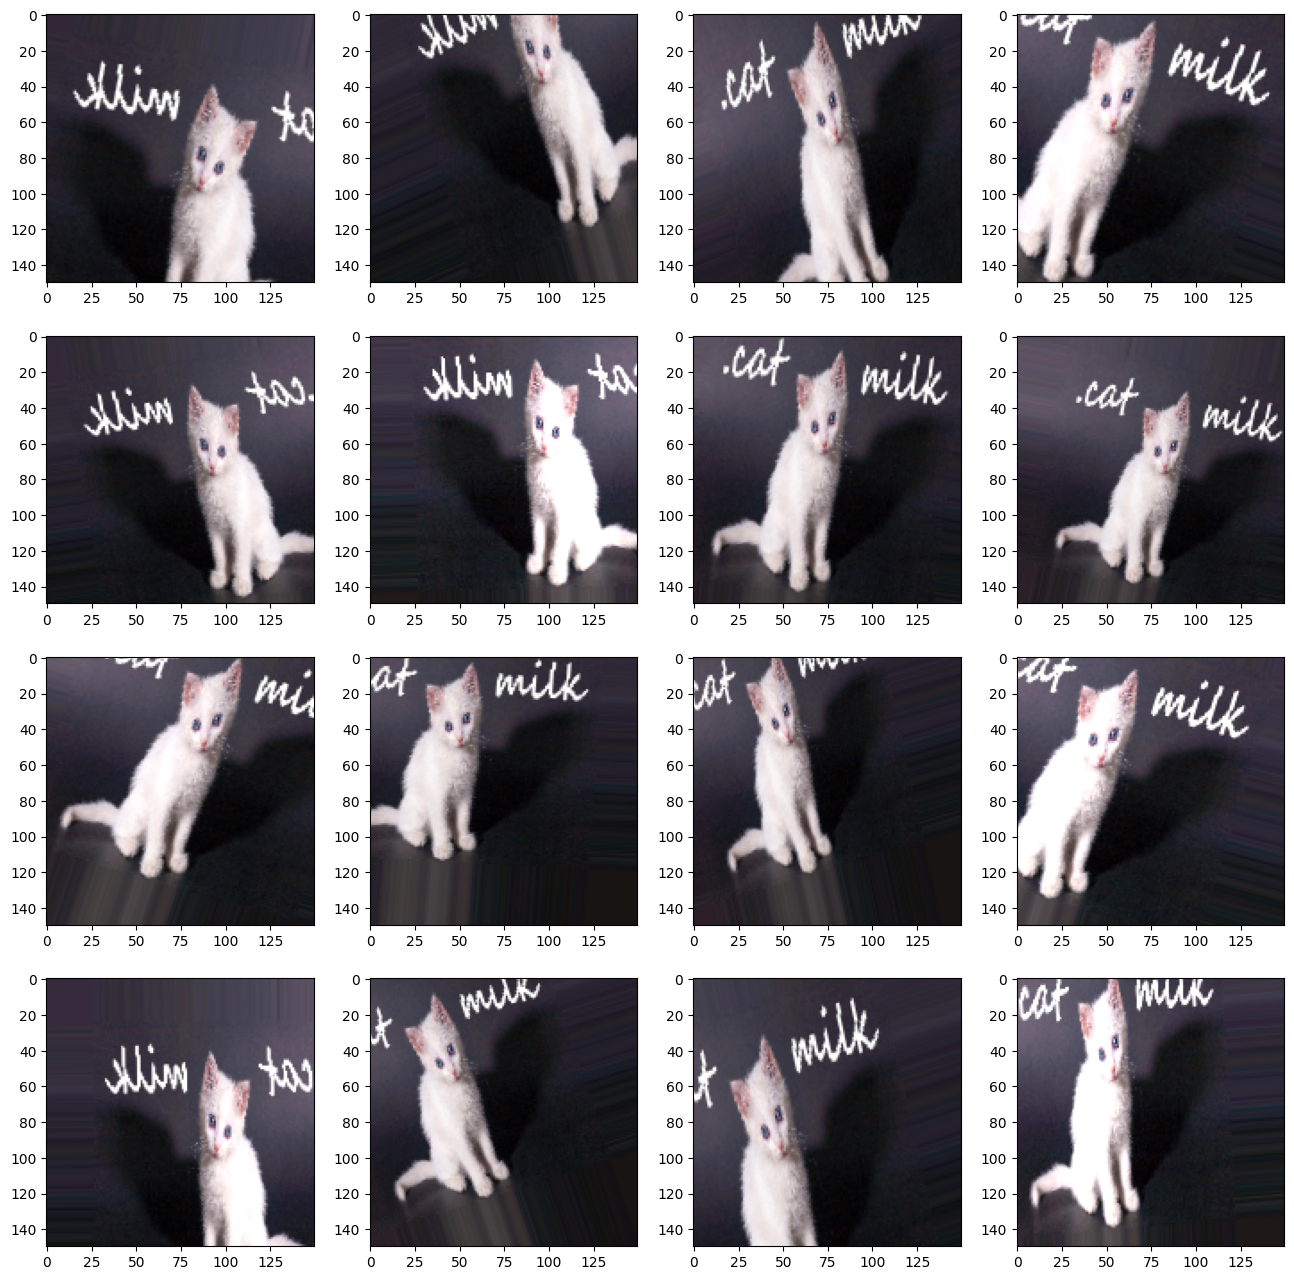

In [13]:
def display_augmented_images(animal, idx):
    fnames = [os.path.join("./img/train/" + animal, fname) for fname in os.listdir("./img/train/" + animal)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))
    print(img_path)

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 1
    plt.figure(figsize=(16, 16))
    for batch in train_datagen.flow(x, batch_size=1):
        img = image.array_to_img(batch[0])

        plt.subplot(4, 4, i)
        plt.grid(False)
        plt.imshow(img)

        i += 1
        if i % 17 == 0: break


display_augmented_images("cat", 100)

In [ ]:
model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(units=512, activation='relu'))
# model.add(Dense(units=256, activation='relu'))
# model.add(Dense(units=1, activation='sigmoid'))

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model.add(conv_base)
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
conv_base.trainable = False

model.summary()

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

batch_size = 32
steps = math.ceil((len(os.listdir(cat_train_dir)) + len(os.listdir(dog_train_dir))) / batch_size)
v_steps = math.ceil((len(os.listdir(cat_validation_dir)) + len(os.listdir(dog_validation_dir))) / batch_size)

mc = ModelCheckpoint(filepath="model4.keras", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps,
                    validation_steps=v_steps,
                    epochs=20,
                    callbacks=[mc])

In [ ]:
def draw_history(history):
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], name="accuracy"))
    fig1.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], name="val_accuracy"))
    fig1.show()

    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], name="loss"))
    fig2.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], name="val_loss"))
    fig2.show()


draw_history(history)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255.)

test_generator = test_datagen.flow_from_directory(directory="./img/test",
                                                  target_size=(150, 150),
                                                  batch_size=1,
                                                  class_mode='binary',
                                                  shuffle=False)

model.load_weights("model4.keras")

probs = model.predict(test_generator, test_generator.samples)

df = pd.DataFrame(
    {"name": test_generator.filepaths, "predictions": np.round(probs).ravel(),
     "classes": test_generator.classes})
df

In [ ]:
good = sum(df['predictions'] == df["classes"])

print(f"Accuracy: {round(good / test_generator.samples * 100, 2)}%")

In [ ]:
print(test_generator.class_indices)

cm = confusion_matrix(df["classes"], df["predictions"])
px.imshow(cm, x=["p_cat", "p_dog"], y=["t_cat", "t_dog"], text_auto=True)

In [ ]:
def display_image(id):
    fnames = [os.path.join("./img/test/cat", fname) for fname in os.listdir("./img/test/cat")]
    fnames += [os.path.join("./img/test/dog", fname) for fname in os.listdir("./img/test/dog")]
    img_path = fnames[id]
    print(img_path)
    img = image.load_img(img_path, target_size=(150, 150))
    img = image.img_to_array(img)

    plt.imshow(img / 255.)


confs = df.index[df['classes'] != df['predictions']].tolist()
print(confs)

display_image(47)